In [1]:
import os
import torch
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

# Dataset class for the custom dataset
class Four4All(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.img_dir, self.labels.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.labels.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [62]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torchvision.models as models
# import torchvision.transforms as transforms
# from torch.utils.data import DataLoader
# from tqdm import tqdm
# import pandas as pd 

# # Check device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using {device} device")

# # Define Transformations (resize, normalize, and augment)
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Required input size for ResNet-50
#     transforms.Grayscale(num_output_channels=3),  # ResNet expects 3 channels
#     transforms.RandomHorizontalFlip(),  # Data Augmentation
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Define dataset paths
# data_directory = 'JAFFE_ResEmoteNet'

# # Load dataset
# train_dataset = Four4All(csv_file=f'{data_directory}/train/train_labels.csv', img_dir=f'{data_directory}/train', transform=transform)
# val_dataset = Four4All(csv_file=f'{data_directory}/validation/validation_labels.csv', img_dir=f'{data_directory}/validation/', transform=transform)
# test_dataset = Four4All(csv_file=f'{data_directory}/test/test_labels.csv', img_dir=f'{data_directory}/test', transform=transform)

# # Create DataLoaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=0)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# # Load Pretrained ResNet-50 model
# model = models.resnet50(pretrained=True)

# # Modify the fully connected layer for FER classification (assuming 6 emotions)
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, 6)  # Change 6 based on your dataset classes

# # Move model to device (GPU if available)
# model = model.to(device)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.00000001, weight_decay=1e-4)  # Lower learning rate for stability

# # Hyperparameters
# num_epochs = 50
# best_val_acc = 0
# patience = 10  # Early stopping patience
# patience_counter = 0

# # Training loop
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     correct, total = 0, 0

#     for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
#         inputs, labels = inputs.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     train_loss = running_loss / len(train_loader)
#     train_acc = correct / total

#     # Validation phase
#     model.eval()
#     val_loss, val_correct, val_total = 0.0, 0, 0
#     with torch.no_grad():
#         for inputs, labels in val_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item()
#             _, predicted = torch.max(outputs, 1)
#             val_total += labels.size(0)
#             val_correct += (predicted == labels).sum().item()

#     val_loss /= len(val_loader)
#     val_acc = val_correct / val_total

#     # Print progress
#     print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

#     # Save best model based on validation accuracy
#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         patience_counter = 0
#         torch.save(model.state_dict(), 'best_resnet50_fer.pth')
#         print("✅ Model saved!")
#     else:
#         patience_counter += 1
#         print(f"⚠️ No improvement in {patience_counter} epochs")

#     # Early stopping
#     if patience_counter >= patience:
#         print("⏹️ Early stopping triggered")
#         break

# # Final testing
# model.load_state_dict(torch.load('best_resnet50_fer.pth'))  # Load best model
# model.eval()
# test_correct, test_total = 0, 0

# with torch.no_grad():
#     for inputs, labels in test_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs, 1)
#         test_total += labels.size(0)
#         test_correct += (predicted == labels).sum().item()

# test_acc = test_correct / test_total
# print(f"Final Test Accuracy: {test_acc:.4f}")

# # Save results
# df = pd.DataFrame({'Epoch': list(range(1, epoch + 2)), 'Train Loss': train_loss, 'Validation Loss': val_loss, 'Train Accuracy': train_acc, 'Validation Accuracy': val_acc, 'Test Accuracy': test_acc})
# df.to_csv('resnet50_fer_results.csv', index=False)


In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Define Transformations (resize, normalize, augment)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet-50 requires 224x224 input size
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale images to 3 channels
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Define dataset paths
data_directory = 'JAFFE_ResEmoteNet'
train_csv = f'{data_directory}/train/train_labels.csv'
val_csv   = f'{data_directory}/validation/validation_labels.csv'
test_csv  = f'{data_directory}/test/test_labels.csv'
train_img_dir = f'{data_directory}/train'
val_img_dir   = f'{data_directory}/validation'
test_img_dir  = f'{data_directory}/test'

# Load datasets (they are defined using the Four4All class)
train_dataset = Four4All(csv_file=train_csv, img_dir=train_img_dir, transform=transform)
val_dataset   = Four4All(csv_file=val_csv,   img_dir=val_img_dir,   transform=transform)
test_dataset  = Four4All(csv_file=test_csv,  img_dir=test_img_dir,  transform=transform)

# Define a grid for hyperparameters
learning_rates = [0.00001, 0.000001]
batch_sizes = [16, 32]
momentums = [0.9, 0.95]
weight_decays = [1e-4, 1e-5]

# To store best hyperparameters and corresponding accuracy
best_val_acc = 0
best_config = {}
results = []

# Grid search loop
for lr in learning_rates:
    for bs in batch_sizes:
        for momentum in momentums:
            for wd in weight_decays:
                print(f"\nTraining with lr={lr}, batch_size={bs}, momentum={momentum}, weight_decay={wd}")

                # Create DataLoaders for current batch size
                train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=0)
                val_loader   = DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=0)
                test_loader  = DataLoader(test_dataset, batch_size=bs, shuffle=False, num_workers=0)

                # Load a pretrained ResNet-50 and modify the FC layer (assuming 6 classes; adjust if needed)
                model = models.resnet50(pretrained=True)
                num_features = model.fc.in_features
                model.fc = nn.Linear(num_features, 6)  # Adjust number of classes as per your dataset
                model = model.to(device)

                # Loss function and optimizer for current config
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

                num_epochs = 50
                patience = 10
                patience_counter = 0
                best_val_acc_config = 0

                # Training loop for current hyperparameters
                for epoch in range(num_epochs):
                    model.train()
                    running_loss = 0.0
                    correct = 0
                    total = 0

                    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
                        inputs, labels = inputs.to(device), labels.to(device)
                        optimizer.zero_grad()
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()

                        running_loss += loss.item()
                        _, predicted = torch.max(outputs, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

                    train_loss = running_loss / len(train_loader)
                    train_acc = correct / total

                    # Evaluate on validation set
                    model.eval()
                    val_running_loss = 0.0
                    val_correct = 0
                    val_total = 0
                    with torch.no_grad():
                        for inputs, labels in val_loader:
                            inputs, labels = inputs.to(device), labels.to(device)
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)
                            val_running_loss += loss.item()
                            _, predicted = torch.max(outputs, 1)
                            val_total += labels.size(0)
                            val_correct += (predicted == labels).sum().item()

                    val_loss = val_running_loss / len(val_loader)
                    val_acc = val_correct / val_total
                    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

                    # Save best model for this hyperparameter configuration
                    if val_acc > best_val_acc_config:
                        best_val_acc_config = val_acc
                        patience_counter = 0
                        torch.save(model.state_dict(), 'temp_best_model.pth')
                    else:
                        patience_counter += 1

                    if patience_counter >= patience:
                        print("Early stopping triggered for this configuration.")
                        break

                # Load the best model for current config (optional evaluation on test set)
                model.load_state_dict(torch.load('temp_best_model.pth'))
                model.eval()
                test_correct = 0
                test_total = 0
                with torch.no_grad():
                    for inputs, labels in test_loader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        outputs = model(inputs)
                        _, predicted = torch.max(outputs, 1)
                        test_total += labels.size(0)
                        test_correct += (predicted == labels).sum().item()
                test_acc = test_correct / test_total

                print(f"Config (lr={lr}, bs={bs}, momentum={momentum}, wd={wd}) => Best Val Acc: {best_val_acc_config:.4f}, Test Acc: {test_acc:.4f}")
                results.append({
                    'lr': lr,
                    'batch_size': bs,
                    'momentum': momentum,
                    'weight_decay': wd,
                    'best_val_acc': best_val_acc_config,
                    'test_acc': test_acc
                })
                # Update global best if applicable
                if best_val_acc_config > best_val_acc:
                    best_val_acc = best_val_acc_config
                    best_config = {'lr': lr, 'batch_size': bs, 'momentum': momentum, 'weight_decay': wd}
                    # Save the best model for overall
                    torch.save(model.state_dict(), 'best_resnet50_fer.pth')

# Convert results to a DataFrame and save to CSV
results_df = pd.DataFrame(results)
results_df.to_csv('resnet50_fer_hyperparameter_results.csv', index=False)

print("Hyperparameter tuning complete.")
print("Best configuration:", best_config)
print("Best validation accuracy:", best_val_acc)

Using cuda device

Training with lr=1e-05, batch_size=16, momentum=0.9, weight_decay=0.0001


c:\MastersRepos\Deep-Learning-For-Computer-Vision\ResEmoteNet\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\MastersRepos\Deep-Learning-For-Computer-Vision\ResEmoteNet\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/50: 100%|██████████| 8/8 [00:01<00:00,  7.34it/s]


Epoch 1: Train Loss: 1.7799, Train Acc: 0.1855, Val Loss: 1.8198, Val Acc: 0.1538


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00,  8.24it/s]


Epoch 2: Train Loss: 1.6211, Train Acc: 0.3710, Val Loss: 1.8052, Val Acc: 0.1538


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00,  8.23it/s]


Epoch 3: Train Loss: 1.4549, Train Acc: 0.6290, Val Loss: 1.7759, Val Acc: 0.1538


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00,  8.35it/s]


Epoch 4: Train Loss: 1.3209, Train Acc: 0.7500, Val Loss: 1.7296, Val Acc: 0.2564


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00,  8.37it/s]


Epoch 5: Train Loss: 1.2090, Train Acc: 0.8468, Val Loss: 1.6452, Val Acc: 0.2564


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00,  8.25it/s]


Epoch 6: Train Loss: 1.1531, Train Acc: 0.8468, Val Loss: 1.6057, Val Acc: 0.3590


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00,  8.32it/s]


Epoch 7: Train Loss: 0.9961, Train Acc: 0.9355, Val Loss: 1.5122, Val Acc: 0.4359


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00,  8.32it/s]


Epoch 8: Train Loss: 0.8747, Train Acc: 0.9194, Val Loss: 1.4141, Val Acc: 0.4359


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00,  8.79it/s]


Epoch 9: Train Loss: 0.8079, Train Acc: 0.9194, Val Loss: 1.3307, Val Acc: 0.4615


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00,  8.88it/s]


Epoch 10: Train Loss: 0.7259, Train Acc: 0.9435, Val Loss: 1.2714, Val Acc: 0.4872


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00,  8.83it/s]


Epoch 11: Train Loss: 0.5948, Train Acc: 0.9435, Val Loss: 1.2181, Val Acc: 0.5641


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00,  8.79it/s]


Epoch 12: Train Loss: 0.5114, Train Acc: 0.9677, Val Loss: 1.1789, Val Acc: 0.5385


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00,  8.99it/s]


Epoch 13: Train Loss: 0.4971, Train Acc: 0.9677, Val Loss: 1.1434, Val Acc: 0.6154


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00,  8.91it/s]


Epoch 14: Train Loss: 0.4084, Train Acc: 0.9516, Val Loss: 1.1471, Val Acc: 0.5897


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00,  8.86it/s]


Epoch 15: Train Loss: 0.3530, Train Acc: 0.9839, Val Loss: 1.0370, Val Acc: 0.6923


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00,  8.79it/s]


Epoch 16: Train Loss: 0.2837, Train Acc: 0.9919, Val Loss: 1.0680, Val Acc: 0.6667


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00,  8.88it/s]


Epoch 17: Train Loss: 0.2911, Train Acc: 0.9758, Val Loss: 0.9800, Val Acc: 0.6410


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00,  8.88it/s]


Epoch 18: Train Loss: 0.2092, Train Acc: 1.0000, Val Loss: 1.0614, Val Acc: 0.6154


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00,  8.83it/s]


Epoch 19: Train Loss: 0.2137, Train Acc: 0.9919, Val Loss: 1.0361, Val Acc: 0.5897


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00,  8.65it/s]


Epoch 20: Train Loss: 0.1962, Train Acc: 0.9919, Val Loss: 0.9688, Val Acc: 0.6154


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00,  8.56it/s]


Epoch 21: Train Loss: 0.1636, Train Acc: 1.0000, Val Loss: 1.0050, Val Acc: 0.6410


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00,  8.67it/s]


Epoch 22: Train Loss: 0.1645, Train Acc: 1.0000, Val Loss: 0.9310, Val Acc: 0.7436


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00,  8.54it/s]


Epoch 23: Train Loss: 0.1215, Train Acc: 1.0000, Val Loss: 0.9233, Val Acc: 0.7179


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00,  8.64it/s]


Epoch 24: Train Loss: 0.1171, Train Acc: 1.0000, Val Loss: 0.8740, Val Acc: 0.7436


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00,  8.69it/s]


Epoch 25: Train Loss: 0.0995, Train Acc: 1.0000, Val Loss: 0.8177, Val Acc: 0.7949


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00,  8.80it/s]


Epoch 26: Train Loss: 0.1113, Train Acc: 1.0000, Val Loss: 0.9405, Val Acc: 0.7436


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00,  8.70it/s]


Epoch 27: Train Loss: 0.1091, Train Acc: 0.9919, Val Loss: 0.9466, Val Acc: 0.7179


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00,  8.73it/s]


Epoch 28: Train Loss: 0.0939, Train Acc: 1.0000, Val Loss: 0.8796, Val Acc: 0.7179


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00,  8.78it/s]


Epoch 29: Train Loss: 0.0872, Train Acc: 1.0000, Val Loss: 0.9153, Val Acc: 0.7436


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00,  8.75it/s]


Epoch 30: Train Loss: 0.0777, Train Acc: 1.0000, Val Loss: 0.8902, Val Acc: 0.7692


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00,  8.77it/s]


Epoch 31: Train Loss: 0.0848, Train Acc: 1.0000, Val Loss: 0.9207, Val Acc: 0.7179


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00,  8.75it/s]


Epoch 32: Train Loss: 0.0751, Train Acc: 0.9919, Val Loss: 0.8729, Val Acc: 0.7692


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00,  8.75it/s]


Epoch 33: Train Loss: 0.0624, Train Acc: 1.0000, Val Loss: 0.9181, Val Acc: 0.7436


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00,  8.80it/s]


Epoch 34: Train Loss: 0.0621, Train Acc: 1.0000, Val Loss: 0.8763, Val Acc: 0.7692


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00,  8.80it/s]


Epoch 35: Train Loss: 0.0797, Train Acc: 1.0000, Val Loss: 0.8796, Val Acc: 0.7179
Early stopping triggered for this configuration.
Config (lr=1e-05, bs=16, momentum=0.9, wd=0.0001) => Best Val Acc: 0.7949, Test Acc: 0.7021

Training with lr=1e-05, batch_size=16, momentum=0.9, weight_decay=1e-05


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00,  8.67it/s]


Epoch 1: Train Loss: 1.7947, Train Acc: 0.1613, Val Loss: 1.7969, Val Acc: 0.1538


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00,  8.86it/s]


Epoch 2: Train Loss: 1.6033, Train Acc: 0.5484, Val Loss: 1.7893, Val Acc: 0.2051


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00,  8.76it/s]


Epoch 3: Train Loss: 1.4676, Train Acc: 0.7661, Val Loss: 1.7433, Val Acc: 0.2564


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00,  8.72it/s]


Epoch 4: Train Loss: 1.3264, Train Acc: 0.8387, Val Loss: 1.7041, Val Acc: 0.2564


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00,  8.63it/s]


Epoch 5: Train Loss: 1.2054, Train Acc: 0.8871, Val Loss: 1.6747, Val Acc: 0.2564


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00,  8.68it/s]


Epoch 6: Train Loss: 1.1094, Train Acc: 0.9032, Val Loss: 1.5622, Val Acc: 0.4103


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00,  8.80it/s]


Epoch 7: Train Loss: 0.9992, Train Acc: 0.8871, Val Loss: 1.5125, Val Acc: 0.4615


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00,  8.73it/s]


Epoch 8: Train Loss: 0.8960, Train Acc: 0.8952, Val Loss: 1.3745, Val Acc: 0.5385


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00,  8.70it/s]


Epoch 9: Train Loss: 0.7416, Train Acc: 0.9597, Val Loss: 1.3205, Val Acc: 0.5897


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00,  8.59it/s]


Epoch 10: Train Loss: 0.6964, Train Acc: 0.9435, Val Loss: 1.3130, Val Acc: 0.5128


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00,  8.70it/s]


Epoch 11: Train Loss: 0.6072, Train Acc: 0.9677, Val Loss: 1.2038, Val Acc: 0.5385


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00,  8.81it/s]


Epoch 12: Train Loss: 0.5515, Train Acc: 0.9677, Val Loss: 1.1440, Val Acc: 0.5897


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00,  8.74it/s]


Epoch 13: Train Loss: 0.4623, Train Acc: 0.9758, Val Loss: 1.1193, Val Acc: 0.6154


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00,  8.86it/s]


Epoch 14: Train Loss: 0.3869, Train Acc: 0.9758, Val Loss: 1.0529, Val Acc: 0.6154


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00,  8.79it/s]


Epoch 15: Train Loss: 0.3567, Train Acc: 0.9758, Val Loss: 1.0513, Val Acc: 0.6410


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00,  8.73it/s]


Epoch 16: Train Loss: 0.2951, Train Acc: 0.9758, Val Loss: 0.9897, Val Acc: 0.6667


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00,  8.62it/s]


Epoch 17: Train Loss: 0.2450, Train Acc: 0.9839, Val Loss: 1.0122, Val Acc: 0.6410


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00,  8.80it/s]


Epoch 18: Train Loss: 0.2234, Train Acc: 1.0000, Val Loss: 0.9681, Val Acc: 0.6667


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00,  8.81it/s]


Epoch 19: Train Loss: 0.2313, Train Acc: 0.9839, Val Loss: 0.9118, Val Acc: 0.6923


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00,  8.47it/s]


Epoch 20: Train Loss: 0.1841, Train Acc: 1.0000, Val Loss: 0.8536, Val Acc: 0.7179


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00,  8.68it/s]


Epoch 21: Train Loss: 0.1587, Train Acc: 1.0000, Val Loss: 0.8376, Val Acc: 0.7692


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00,  8.78it/s]


Epoch 22: Train Loss: 0.1661, Train Acc: 1.0000, Val Loss: 0.8528, Val Acc: 0.6667


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00,  8.60it/s]


Epoch 23: Train Loss: 0.1460, Train Acc: 1.0000, Val Loss: 0.8641, Val Acc: 0.7179


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00,  8.70it/s]


Epoch 24: Train Loss: 0.1357, Train Acc: 1.0000, Val Loss: 0.8387, Val Acc: 0.6410


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00,  8.83it/s]


Epoch 25: Train Loss: 0.1250, Train Acc: 1.0000, Val Loss: 0.8422, Val Acc: 0.6923


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00,  8.55it/s]


Epoch 26: Train Loss: 0.1000, Train Acc: 1.0000, Val Loss: 0.8654, Val Acc: 0.7436


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00,  8.76it/s]


Epoch 27: Train Loss: 0.0805, Train Acc: 1.0000, Val Loss: 0.8521, Val Acc: 0.7692


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00,  8.73it/s]


Epoch 28: Train Loss: 0.0972, Train Acc: 1.0000, Val Loss: 0.8549, Val Acc: 0.7436


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00,  8.72it/s]


Epoch 29: Train Loss: 0.0909, Train Acc: 1.0000, Val Loss: 0.8031, Val Acc: 0.7436


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00,  8.72it/s]


Epoch 30: Train Loss: 0.0613, Train Acc: 1.0000, Val Loss: 0.8907, Val Acc: 0.7179


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00,  8.80it/s]


Epoch 31: Train Loss: 0.0697, Train Acc: 1.0000, Val Loss: 0.8358, Val Acc: 0.7692
Early stopping triggered for this configuration.
Config (lr=1e-05, bs=16, momentum=0.9, wd=1e-05) => Best Val Acc: 0.7692, Test Acc: 0.7021

Training with lr=1e-05, batch_size=16, momentum=0.95, weight_decay=0.0001


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00,  8.62it/s]


Epoch 1: Train Loss: 1.8173, Train Acc: 0.1694, Val Loss: 1.8494, Val Acc: 0.1795


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00,  8.74it/s]


Epoch 2: Train Loss: 1.6415, Train Acc: 0.3790, Val Loss: 1.8339, Val Acc: 0.2051


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00,  8.70it/s]


Epoch 3: Train Loss: 1.5379, Train Acc: 0.5484, Val Loss: 1.7822, Val Acc: 0.1795


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00,  8.88it/s]


Epoch 4: Train Loss: 1.4106, Train Acc: 0.7258, Val Loss: 1.7492, Val Acc: 0.2051


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00,  8.65it/s]


Epoch 5: Train Loss: 1.2667, Train Acc: 0.8306, Val Loss: 1.6928, Val Acc: 0.2308


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00,  8.69it/s]


Epoch 6: Train Loss: 1.1803, Train Acc: 0.8790, Val Loss: 1.5889, Val Acc: 0.2564


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00,  8.74it/s]


Epoch 7: Train Loss: 1.0261, Train Acc: 0.9435, Val Loss: 1.4928, Val Acc: 0.3846


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00,  8.79it/s]


Epoch 8: Train Loss: 0.9559, Train Acc: 0.9113, Val Loss: 1.4329, Val Acc: 0.4615


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00,  8.60it/s]


Epoch 9: Train Loss: 0.8345, Train Acc: 0.9677, Val Loss: 1.3288, Val Acc: 0.5641


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00,  8.76it/s]


Epoch 10: Train Loss: 0.7472, Train Acc: 0.9435, Val Loss: 1.2650, Val Acc: 0.5128


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00,  8.40it/s]


Epoch 11: Train Loss: 0.6332, Train Acc: 0.9677, Val Loss: 1.2738, Val Acc: 0.5128


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00,  8.86it/s]


Epoch 12: Train Loss: 0.5469, Train Acc: 0.9677, Val Loss: 1.2016, Val Acc: 0.5128


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00,  8.81it/s]


Epoch 13: Train Loss: 0.5026, Train Acc: 0.9516, Val Loss: 1.0709, Val Acc: 0.5897


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00,  8.80it/s]


Epoch 14: Train Loss: 0.4409, Train Acc: 0.9677, Val Loss: 1.0649, Val Acc: 0.5897


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00,  8.63it/s]


Epoch 15: Train Loss: 0.3697, Train Acc: 0.9839, Val Loss: 1.0436, Val Acc: 0.5897


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00,  8.86it/s]


Epoch 16: Train Loss: 0.3219, Train Acc: 0.9758, Val Loss: 1.0290, Val Acc: 0.5897


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00,  8.79it/s]


Epoch 17: Train Loss: 0.2794, Train Acc: 0.9839, Val Loss: 0.9268, Val Acc: 0.6667


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00,  8.77it/s]


Epoch 18: Train Loss: 0.2769, Train Acc: 0.9758, Val Loss: 0.9528, Val Acc: 0.6667


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00,  8.80it/s]


Epoch 19: Train Loss: 0.2684, Train Acc: 0.9758, Val Loss: 0.9383, Val Acc: 0.6667


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00,  8.80it/s]


Epoch 20: Train Loss: 0.2415, Train Acc: 0.9758, Val Loss: 0.9789, Val Acc: 0.5641


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00,  8.72it/s]


Epoch 21: Train Loss: 0.1782, Train Acc: 1.0000, Val Loss: 0.9382, Val Acc: 0.6410


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00,  8.75it/s]


Epoch 22: Train Loss: 0.1751, Train Acc: 0.9919, Val Loss: 0.8999, Val Acc: 0.5897


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00,  8.80it/s]


Epoch 23: Train Loss: 0.1392, Train Acc: 1.0000, Val Loss: 0.7844, Val Acc: 0.6923


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00,  8.86it/s]


Epoch 24: Train Loss: 0.1430, Train Acc: 0.9919, Val Loss: 0.8315, Val Acc: 0.6667


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00,  8.80it/s]


Epoch 25: Train Loss: 0.1125, Train Acc: 1.0000, Val Loss: 0.8893, Val Acc: 0.6410


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00,  8.75it/s]


Epoch 26: Train Loss: 0.0893, Train Acc: 1.0000, Val Loss: 0.8427, Val Acc: 0.7436


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00,  8.72it/s]


Epoch 27: Train Loss: 0.1059, Train Acc: 1.0000, Val Loss: 0.7941, Val Acc: 0.7179


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00,  8.73it/s]


Epoch 28: Train Loss: 0.0764, Train Acc: 1.0000, Val Loss: 0.7517, Val Acc: 0.7436


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00,  8.78it/s]


Epoch 29: Train Loss: 0.0837, Train Acc: 1.0000, Val Loss: 0.8997, Val Acc: 0.6667


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00,  8.71it/s]


Epoch 30: Train Loss: 0.0730, Train Acc: 1.0000, Val Loss: 0.8345, Val Acc: 0.6667


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00,  8.69it/s]


Epoch 31: Train Loss: 0.0786, Train Acc: 1.0000, Val Loss: 0.7959, Val Acc: 0.6667


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00,  8.78it/s]


Epoch 32: Train Loss: 0.0684, Train Acc: 1.0000, Val Loss: 0.8177, Val Acc: 0.6923


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00,  8.77it/s]


Epoch 33: Train Loss: 0.0533, Train Acc: 1.0000, Val Loss: 0.8233, Val Acc: 0.6410


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00,  8.63it/s]


Epoch 34: Train Loss: 0.0833, Train Acc: 0.9919, Val Loss: 0.8695, Val Acc: 0.7436


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00,  8.19it/s]


Epoch 35: Train Loss: 0.0480, Train Acc: 1.0000, Val Loss: 0.8087, Val Acc: 0.6410


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00,  8.16it/s]


Epoch 36: Train Loss: 0.0458, Train Acc: 1.0000, Val Loss: 0.7526, Val Acc: 0.7436
Early stopping triggered for this configuration.
Config (lr=1e-05, bs=16, momentum=0.95, wd=0.0001) => Best Val Acc: 0.7436, Test Acc: 0.6596

Training with lr=1e-05, batch_size=16, momentum=0.95, weight_decay=1e-05


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00,  8.15it/s]


Epoch 1: Train Loss: 1.7442, Train Acc: 0.2097, Val Loss: 1.7724, Val Acc: 0.2308


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00,  8.14it/s]


Epoch 2: Train Loss: 1.5960, Train Acc: 0.3871, Val Loss: 1.7332, Val Acc: 0.2308


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00,  8.17it/s]


Epoch 3: Train Loss: 1.4522, Train Acc: 0.6210, Val Loss: 1.7000, Val Acc: 0.2051


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00,  8.21it/s]


Epoch 4: Train Loss: 1.3327, Train Acc: 0.7661, Val Loss: 1.6727, Val Acc: 0.2051


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00,  8.16it/s]


Epoch 5: Train Loss: 1.2402, Train Acc: 0.7984, Val Loss: 1.6210, Val Acc: 0.2821


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00,  8.08it/s]


Epoch 6: Train Loss: 1.1421, Train Acc: 0.8790, Val Loss: 1.5672, Val Acc: 0.3590


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00,  8.12it/s]


Epoch 7: Train Loss: 1.0182, Train Acc: 0.8710, Val Loss: 1.5109, Val Acc: 0.4615


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00,  8.25it/s]


Epoch 8: Train Loss: 0.9342, Train Acc: 0.9194, Val Loss: 1.4156, Val Acc: 0.4872


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00,  8.14it/s]


Epoch 9: Train Loss: 0.8078, Train Acc: 0.9113, Val Loss: 1.3477, Val Acc: 0.5385


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00,  8.15it/s]


Epoch 10: Train Loss: 0.7291, Train Acc: 0.9516, Val Loss: 1.2816, Val Acc: 0.5385


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00,  8.14it/s]


Epoch 11: Train Loss: 0.6784, Train Acc: 0.9435, Val Loss: 1.2233, Val Acc: 0.5897


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00,  8.20it/s]


Epoch 12: Train Loss: 0.5972, Train Acc: 0.9355, Val Loss: 1.1498, Val Acc: 0.5897


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00,  8.11it/s]


Epoch 13: Train Loss: 0.5164, Train Acc: 0.9597, Val Loss: 1.1116, Val Acc: 0.6667


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00,  8.30it/s]


Epoch 14: Train Loss: 0.4330, Train Acc: 0.9597, Val Loss: 1.1328, Val Acc: 0.5641


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00,  8.16it/s]


Epoch 15: Train Loss: 0.3729, Train Acc: 0.9839, Val Loss: 1.1252, Val Acc: 0.5641


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00,  8.15it/s]


Epoch 16: Train Loss: 0.3585, Train Acc: 0.9758, Val Loss: 1.0308, Val Acc: 0.6410


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00,  8.21it/s]


Epoch 17: Train Loss: 0.2746, Train Acc: 0.9839, Val Loss: 1.0204, Val Acc: 0.6154


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00,  8.26it/s]


Epoch 18: Train Loss: 0.2620, Train Acc: 0.9919, Val Loss: 0.9944, Val Acc: 0.6154


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00,  8.18it/s]


Epoch 19: Train Loss: 0.2562, Train Acc: 1.0000, Val Loss: 1.0412, Val Acc: 0.6154


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00,  8.74it/s]


Epoch 20: Train Loss: 0.2271, Train Acc: 0.9839, Val Loss: 1.0035, Val Acc: 0.6154


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00,  8.81it/s]


Epoch 21: Train Loss: 0.2234, Train Acc: 0.9919, Val Loss: 0.9785, Val Acc: 0.6154


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00,  8.75it/s]


Epoch 22: Train Loss: 0.1916, Train Acc: 0.9919, Val Loss: 0.9007, Val Acc: 0.6154


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00,  8.70it/s]


Epoch 23: Train Loss: 0.1383, Train Acc: 1.0000, Val Loss: 0.9486, Val Acc: 0.5641
Early stopping triggered for this configuration.
Config (lr=1e-05, bs=16, momentum=0.95, wd=1e-05) => Best Val Acc: 0.6667, Test Acc: 0.7021

Training with lr=1e-05, batch_size=32, momentum=0.9, weight_decay=0.0001


Epoch 1/50: 100%|██████████| 4/4 [00:00<00:00,  4.45it/s]


Epoch 1: Train Loss: 1.8323, Train Acc: 0.1532, Val Loss: 1.8058, Val Acc: 0.1538


Epoch 2/50: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch 2: Train Loss: 1.6968, Train Acc: 0.3387, Val Loss: 1.7768, Val Acc: 0.2051


Epoch 3/50: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Epoch 3: Train Loss: 1.5911, Train Acc: 0.5484, Val Loss: 1.7631, Val Acc: 0.2308


Epoch 4/50: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Epoch 4: Train Loss: 1.4864, Train Acc: 0.6935, Val Loss: 1.7571, Val Acc: 0.2564


Epoch 5/50: 100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


Epoch 5: Train Loss: 1.3995, Train Acc: 0.7903, Val Loss: 1.7292, Val Acc: 0.2564


Epoch 6/50: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


Epoch 6: Train Loss: 1.3028, Train Acc: 0.8468, Val Loss: 1.7054, Val Acc: 0.2564


Epoch 7/50: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch 7: Train Loss: 1.2165, Train Acc: 0.8548, Val Loss: 1.6680, Val Acc: 0.2821


Epoch 8/50: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Epoch 8: Train Loss: 1.1600, Train Acc: 0.9113, Val Loss: 1.6187, Val Acc: 0.3077


Epoch 9/50: 100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Epoch 9: Train Loss: 1.0602, Train Acc: 0.9274, Val Loss: 1.5950, Val Acc: 0.3077


Epoch 10/50: 100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


Epoch 10: Train Loss: 0.9849, Train Acc: 0.9435, Val Loss: 1.5576, Val Acc: 0.3590


Epoch 11/50: 100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


Epoch 11: Train Loss: 0.9236, Train Acc: 0.9677, Val Loss: 1.5149, Val Acc: 0.3590


Epoch 12/50: 100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Epoch 12: Train Loss: 0.8136, Train Acc: 0.9677, Val Loss: 1.4187, Val Acc: 0.5128


Epoch 13/50: 100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch 13: Train Loss: 0.8341, Train Acc: 0.9113, Val Loss: 1.4297, Val Acc: 0.4103


Epoch 14/50: 100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


Epoch 14: Train Loss: 0.7300, Train Acc: 0.9597, Val Loss: 1.3727, Val Acc: 0.4359


Epoch 15/50: 100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


Epoch 15: Train Loss: 0.6525, Train Acc: 0.9839, Val Loss: 1.2680, Val Acc: 0.5385


Epoch 16/50: 100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


Epoch 16: Train Loss: 0.5866, Train Acc: 0.9839, Val Loss: 1.2538, Val Acc: 0.4872


Epoch 17/50: 100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


Epoch 17: Train Loss: 0.5341, Train Acc: 0.9839, Val Loss: 1.2034, Val Acc: 0.5128


Epoch 18/50: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch 18: Train Loss: 0.5056, Train Acc: 0.9919, Val Loss: 1.2327, Val Acc: 0.4359


Epoch 19/50: 100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


Epoch 19: Train Loss: 0.4357, Train Acc: 1.0000, Val Loss: 1.1657, Val Acc: 0.5385


Epoch 20/50: 100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


Epoch 20: Train Loss: 0.3958, Train Acc: 1.0000, Val Loss: 1.1779, Val Acc: 0.5897


Epoch 21/50: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


Epoch 21: Train Loss: 0.3762, Train Acc: 1.0000, Val Loss: 1.1266, Val Acc: 0.5641


Epoch 22/50: 100%|██████████| 4/4 [00:00<00:00,  4.40it/s]


Epoch 22: Train Loss: 0.3396, Train Acc: 0.9839, Val Loss: 1.0967, Val Acc: 0.5897


Epoch 23/50: 100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


Epoch 23: Train Loss: 0.3030, Train Acc: 0.9919, Val Loss: 1.1037, Val Acc: 0.5897


Epoch 24/50: 100%|██████████| 4/4 [00:00<00:00,  4.39it/s]


Epoch 24: Train Loss: 0.2724, Train Acc: 0.9919, Val Loss: 1.0107, Val Acc: 0.6154


Epoch 25/50: 100%|██████████| 4/4 [00:00<00:00,  4.39it/s]


Epoch 25: Train Loss: 0.2364, Train Acc: 1.0000, Val Loss: 1.0489, Val Acc: 0.6410


Epoch 26/50: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


Epoch 26: Train Loss: 0.2317, Train Acc: 1.0000, Val Loss: 1.0994, Val Acc: 0.6410


Epoch 27/50: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s]


Epoch 27: Train Loss: 0.2116, Train Acc: 0.9919, Val Loss: 0.9819, Val Acc: 0.6667


Epoch 28/50: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s]


Epoch 28: Train Loss: 0.1761, Train Acc: 1.0000, Val Loss: 0.9500, Val Acc: 0.7179


Epoch 29/50: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


Epoch 29: Train Loss: 0.1520, Train Acc: 1.0000, Val Loss: 0.9671, Val Acc: 0.6923


Epoch 30/50: 100%|██████████| 4/4 [00:00<00:00,  4.52it/s]


Epoch 30: Train Loss: 0.1435, Train Acc: 1.0000, Val Loss: 0.9861, Val Acc: 0.6923


Epoch 31/50: 100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


Epoch 31: Train Loss: 0.1542, Train Acc: 1.0000, Val Loss: 0.9539, Val Acc: 0.6923


Epoch 32/50: 100%|██████████| 4/4 [00:00<00:00,  4.55it/s]


Epoch 32: Train Loss: 0.1269, Train Acc: 1.0000, Val Loss: 0.9184, Val Acc: 0.6667


Epoch 33/50: 100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch 33: Train Loss: 0.1074, Train Acc: 1.0000, Val Loss: 0.9940, Val Acc: 0.7436


Epoch 34/50: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


Epoch 34: Train Loss: 0.1230, Train Acc: 1.0000, Val Loss: 0.9842, Val Acc: 0.6923


Epoch 35/50: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


Epoch 35: Train Loss: 0.0916, Train Acc: 1.0000, Val Loss: 1.0573, Val Acc: 0.6667


Epoch 36/50: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


Epoch 36: Train Loss: 0.0838, Train Acc: 1.0000, Val Loss: 0.9867, Val Acc: 0.7179


Epoch 37/50: 100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


Epoch 37: Train Loss: 0.0842, Train Acc: 1.0000, Val Loss: 0.9248, Val Acc: 0.7179


Epoch 38/50: 100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Epoch 38: Train Loss: 0.0824, Train Acc: 1.0000, Val Loss: 0.9722, Val Acc: 0.6667


Epoch 39/50: 100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


Epoch 39: Train Loss: 0.0710, Train Acc: 1.0000, Val Loss: 0.9171, Val Acc: 0.7436


Epoch 40/50: 100%|██████████| 4/4 [00:00<00:00,  4.62it/s]


Epoch 40: Train Loss: 0.0624, Train Acc: 1.0000, Val Loss: 0.8499, Val Acc: 0.6923


Epoch 41/50: 100%|██████████| 4/4 [00:00<00:00,  4.56it/s]


Epoch 41: Train Loss: 0.0747, Train Acc: 1.0000, Val Loss: 0.9594, Val Acc: 0.7179


Epoch 42/50: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Epoch 42: Train Loss: 0.0537, Train Acc: 1.0000, Val Loss: 0.8726, Val Acc: 0.7436


Epoch 43/50: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch 43: Train Loss: 0.0567, Train Acc: 1.0000, Val Loss: 0.8834, Val Acc: 0.7692


Epoch 44/50: 100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch 44: Train Loss: 0.0524, Train Acc: 1.0000, Val Loss: 0.9346, Val Acc: 0.7436


Epoch 45/50: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Epoch 45: Train Loss: 0.0483, Train Acc: 1.0000, Val Loss: 0.7991, Val Acc: 0.7436


Epoch 46/50: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


Epoch 46: Train Loss: 0.0451, Train Acc: 1.0000, Val Loss: 0.8535, Val Acc: 0.7179


Epoch 47/50: 100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


Epoch 47: Train Loss: 0.0462, Train Acc: 1.0000, Val Loss: 0.8973, Val Acc: 0.7692


Epoch 48/50: 100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Epoch 48: Train Loss: 0.0440, Train Acc: 1.0000, Val Loss: 0.8912, Val Acc: 0.7692


Epoch 49/50: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


Epoch 49: Train Loss: 0.0472, Train Acc: 1.0000, Val Loss: 0.9617, Val Acc: 0.7692


Epoch 50/50: 100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


Epoch 50: Train Loss: 0.0381, Train Acc: 1.0000, Val Loss: 0.8688, Val Acc: 0.7436
Config (lr=1e-05, bs=32, momentum=0.9, wd=0.0001) => Best Val Acc: 0.7692, Test Acc: 0.5745

Training with lr=1e-05, batch_size=32, momentum=0.9, weight_decay=1e-05


Epoch 1/50: 100%|██████████| 4/4 [00:00<00:00,  4.59it/s]


Epoch 1: Train Loss: 1.7667, Train Acc: 0.2419, Val Loss: 1.6917, Val Acc: 0.2564


Epoch 2/50: 100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


Epoch 2: Train Loss: 1.6395, Train Acc: 0.3145, Val Loss: 1.6717, Val Acc: 0.2564


Epoch 3/50: 100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


Epoch 3: Train Loss: 1.5627, Train Acc: 0.4113, Val Loss: 1.6528, Val Acc: 0.2821


Epoch 4/50: 100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


Epoch 4: Train Loss: 1.4518, Train Acc: 0.5161, Val Loss: 1.6275, Val Acc: 0.2821


Epoch 5/50: 100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


Epoch 5: Train Loss: 1.3607, Train Acc: 0.6452, Val Loss: 1.6176, Val Acc: 0.2564


Epoch 6/50: 100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Epoch 6: Train Loss: 1.2795, Train Acc: 0.6935, Val Loss: 1.6035, Val Acc: 0.2821


Epoch 7/50: 100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


Epoch 7: Train Loss: 1.2064, Train Acc: 0.7661, Val Loss: 1.5338, Val Acc: 0.4103


Epoch 8/50: 100%|██████████| 4/4 [00:00<00:00,  4.54it/s]


Epoch 8: Train Loss: 1.1177, Train Acc: 0.8790, Val Loss: 1.5307, Val Acc: 0.4103


Epoch 9/50: 100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


Epoch 9: Train Loss: 1.0596, Train Acc: 0.8952, Val Loss: 1.5132, Val Acc: 0.3590


Epoch 10/50: 100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


Epoch 10: Train Loss: 0.9769, Train Acc: 0.9355, Val Loss: 1.4363, Val Acc: 0.4615


Epoch 11/50: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


Epoch 11: Train Loss: 0.9184, Train Acc: 0.9435, Val Loss: 1.4643, Val Acc: 0.5128


Epoch 12/50: 100%|██████████| 4/4 [00:00<00:00,  4.61it/s]


Epoch 12: Train Loss: 0.8760, Train Acc: 0.9274, Val Loss: 1.4076, Val Acc: 0.5128


Epoch 13/50: 100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Epoch 13: Train Loss: 0.7842, Train Acc: 0.9597, Val Loss: 1.3124, Val Acc: 0.5385


Epoch 14/50: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


Epoch 14: Train Loss: 0.6991, Train Acc: 0.9677, Val Loss: 1.2704, Val Acc: 0.5641


Epoch 15/50: 100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


Epoch 15: Train Loss: 0.6682, Train Acc: 0.9677, Val Loss: 1.2391, Val Acc: 0.5385


Epoch 16/50: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Epoch 16: Train Loss: 0.5828, Train Acc: 0.9839, Val Loss: 1.1928, Val Acc: 0.6410


Epoch 17/50: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


Epoch 17: Train Loss: 0.5527, Train Acc: 0.9839, Val Loss: 1.1273, Val Acc: 0.6410


Epoch 18/50: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch 18: Train Loss: 0.4998, Train Acc: 0.9839, Val Loss: 1.0746, Val Acc: 0.6667


Epoch 19/50: 100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


Epoch 19: Train Loss: 0.4435, Train Acc: 0.9758, Val Loss: 1.0840, Val Acc: 0.6154


Epoch 20/50: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


Epoch 20: Train Loss: 0.4183, Train Acc: 1.0000, Val Loss: 1.0595, Val Acc: 0.6154


Epoch 21/50: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


Epoch 21: Train Loss: 0.3686, Train Acc: 0.9919, Val Loss: 1.0483, Val Acc: 0.5897


Epoch 22/50: 100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Epoch 22: Train Loss: 0.3247, Train Acc: 1.0000, Val Loss: 1.0097, Val Acc: 0.6410


Epoch 23/50: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


Epoch 23: Train Loss: 0.2965, Train Acc: 0.9919, Val Loss: 0.9588, Val Acc: 0.6410


Epoch 24/50: 100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


Epoch 24: Train Loss: 0.2718, Train Acc: 0.9919, Val Loss: 0.9569, Val Acc: 0.5897


Epoch 25/50: 100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


Epoch 25: Train Loss: 0.2426, Train Acc: 1.0000, Val Loss: 0.9203, Val Acc: 0.6410


Epoch 26/50: 100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Epoch 26: Train Loss: 0.2348, Train Acc: 0.9919, Val Loss: 0.8986, Val Acc: 0.6410


Epoch 27/50: 100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


Epoch 27: Train Loss: 0.2120, Train Acc: 1.0000, Val Loss: 0.8928, Val Acc: 0.6410


Epoch 28/50: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


Epoch 28: Train Loss: 0.2055, Train Acc: 1.0000, Val Loss: 0.8726, Val Acc: 0.7179


Epoch 29/50: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Epoch 29: Train Loss: 0.1737, Train Acc: 1.0000, Val Loss: 0.8710, Val Acc: 0.6410


Epoch 30/50: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


Epoch 30: Train Loss: 0.1430, Train Acc: 1.0000, Val Loss: 0.8697, Val Acc: 0.6923


Epoch 31/50: 100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch 31: Train Loss: 0.1540, Train Acc: 1.0000, Val Loss: 0.8922, Val Acc: 0.6923


Epoch 32/50: 100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


Epoch 32: Train Loss: 0.1252, Train Acc: 1.0000, Val Loss: 0.8367, Val Acc: 0.7179


Epoch 33/50: 100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch 33: Train Loss: 0.1331, Train Acc: 1.0000, Val Loss: 0.8212, Val Acc: 0.6923


Epoch 34/50: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


Epoch 34: Train Loss: 0.1156, Train Acc: 1.0000, Val Loss: 0.8432, Val Acc: 0.7179


Epoch 35/50: 100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch 35: Train Loss: 0.1094, Train Acc: 1.0000, Val Loss: 0.8197, Val Acc: 0.6923


Epoch 36/50: 100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


Epoch 36: Train Loss: 0.0902, Train Acc: 1.0000, Val Loss: 0.7839, Val Acc: 0.6923


Epoch 37/50: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Epoch 37: Train Loss: 0.0869, Train Acc: 1.0000, Val Loss: 0.7880, Val Acc: 0.7179


Epoch 38/50: 100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


Epoch 38: Train Loss: 0.0834, Train Acc: 1.0000, Val Loss: 0.7657, Val Acc: 0.7179
Early stopping triggered for this configuration.
Config (lr=1e-05, bs=32, momentum=0.9, wd=1e-05) => Best Val Acc: 0.7179, Test Acc: 0.6383

Training with lr=1e-05, batch_size=32, momentum=0.95, weight_decay=0.0001


Epoch 1/50: 100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


Epoch 1: Train Loss: 1.8179, Train Acc: 0.1452, Val Loss: 1.8284, Val Acc: 0.1282


Epoch 2/50: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Epoch 2: Train Loss: 1.6835, Train Acc: 0.3145, Val Loss: 1.7973, Val Acc: 0.1282


Epoch 3/50: 100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


Epoch 3: Train Loss: 1.5670, Train Acc: 0.4597, Val Loss: 1.7945, Val Acc: 0.1282


Epoch 4/50: 100%|██████████| 4/4 [00:00<00:00,  4.44it/s]


Epoch 4: Train Loss: 1.4702, Train Acc: 0.5806, Val Loss: 1.7683, Val Acc: 0.1282


Epoch 5/50: 100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Epoch 5: Train Loss: 1.3784, Train Acc: 0.6613, Val Loss: 1.7491, Val Acc: 0.1282


Epoch 6/50: 100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Epoch 6: Train Loss: 1.2657, Train Acc: 0.7339, Val Loss: 1.7111, Val Acc: 0.1538


Epoch 7/50: 100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


Epoch 7: Train Loss: 1.1893, Train Acc: 0.8065, Val Loss: 1.7275, Val Acc: 0.1282


Epoch 8/50: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


Epoch 8: Train Loss: 1.0790, Train Acc: 0.8952, Val Loss: 1.6810, Val Acc: 0.1538


Epoch 9/50: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


Epoch 9: Train Loss: 1.0171, Train Acc: 0.9194, Val Loss: 1.6813, Val Acc: 0.1538


Epoch 10/50: 100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


Epoch 10: Train Loss: 0.9926, Train Acc: 0.8952, Val Loss: 1.6105, Val Acc: 0.1538


Epoch 11/50: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


Epoch 11: Train Loss: 0.8633, Train Acc: 0.9274, Val Loss: 1.5596, Val Acc: 0.2051


Epoch 12/50: 100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Epoch 12: Train Loss: 0.8129, Train Acc: 0.9274, Val Loss: 1.4611, Val Acc: 0.4103


Epoch 13/50: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Epoch 13: Train Loss: 0.7088, Train Acc: 0.9435, Val Loss: 1.3502, Val Acc: 0.5385


Epoch 14/50: 100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


Epoch 14: Train Loss: 0.6405, Train Acc: 0.9758, Val Loss: 1.2522, Val Acc: 0.5641


Epoch 15/50: 100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


Epoch 15: Train Loss: 0.6271, Train Acc: 0.9597, Val Loss: 1.2223, Val Acc: 0.6154


Epoch 16/50: 100%|██████████| 4/4 [00:00<00:00,  4.61it/s]


Epoch 16: Train Loss: 0.5421, Train Acc: 0.9758, Val Loss: 1.1728, Val Acc: 0.6410


Epoch 17/50: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


Epoch 17: Train Loss: 0.5125, Train Acc: 0.9597, Val Loss: 1.1138, Val Acc: 0.6154


Epoch 18/50: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Epoch 18: Train Loss: 0.4387, Train Acc: 0.9839, Val Loss: 1.1335, Val Acc: 0.6667


Epoch 19/50: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


Epoch 19: Train Loss: 0.4172, Train Acc: 0.9839, Val Loss: 1.0648, Val Acc: 0.6410


Epoch 20/50: 100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


Epoch 20: Train Loss: 0.3749, Train Acc: 0.9677, Val Loss: 1.0787, Val Acc: 0.6410


Epoch 21/50: 100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


Epoch 21: Train Loss: 0.3244, Train Acc: 0.9839, Val Loss: 1.0168, Val Acc: 0.5897


Epoch 22/50: 100%|██████████| 4/4 [00:00<00:00,  4.57it/s]


Epoch 22: Train Loss: 0.2979, Train Acc: 0.9839, Val Loss: 0.9547, Val Acc: 0.6923


Epoch 23/50: 100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


Epoch 23: Train Loss: 0.2615, Train Acc: 1.0000, Val Loss: 0.9888, Val Acc: 0.6410


Epoch 24/50: 100%|██████████| 4/4 [00:00<00:00,  4.62it/s]


Epoch 24: Train Loss: 0.2519, Train Acc: 0.9839, Val Loss: 0.8891, Val Acc: 0.6410


Epoch 25/50: 100%|██████████| 4/4 [00:00<00:00,  4.59it/s]


Epoch 25: Train Loss: 0.2256, Train Acc: 0.9919, Val Loss: 0.9096, Val Acc: 0.6667


Epoch 26/50: 100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch 26: Train Loss: 0.2213, Train Acc: 0.9919, Val Loss: 0.9461, Val Acc: 0.6667


Epoch 27/50: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch 27: Train Loss: 0.2018, Train Acc: 0.9919, Val Loss: 0.8470, Val Acc: 0.6410


Epoch 28/50: 100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch 28: Train Loss: 0.1777, Train Acc: 1.0000, Val Loss: 0.9402, Val Acc: 0.7179


Epoch 29/50: 100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


Epoch 29: Train Loss: 0.1469, Train Acc: 1.0000, Val Loss: 0.9235, Val Acc: 0.7179


Epoch 30/50: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


Epoch 30: Train Loss: 0.1566, Train Acc: 1.0000, Val Loss: 0.8778, Val Acc: 0.6667


Epoch 31/50: 100%|██████████| 4/4 [00:00<00:00,  4.61it/s]


Epoch 31: Train Loss: 0.1409, Train Acc: 0.9839, Val Loss: 0.8626, Val Acc: 0.6923


Epoch 32/50: 100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


Epoch 32: Train Loss: 0.1158, Train Acc: 1.0000, Val Loss: 0.8390, Val Acc: 0.6667


Epoch 33/50: 100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


Epoch 33: Train Loss: 0.1168, Train Acc: 1.0000, Val Loss: 0.8645, Val Acc: 0.7179


Epoch 34/50: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


Epoch 34: Train Loss: 0.0998, Train Acc: 1.0000, Val Loss: 0.8161, Val Acc: 0.6923


Epoch 35/50: 100%|██████████| 4/4 [00:00<00:00,  4.61it/s]


Epoch 35: Train Loss: 0.0961, Train Acc: 1.0000, Val Loss: 0.8279, Val Acc: 0.7436


Epoch 36/50: 100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


Epoch 36: Train Loss: 0.0839, Train Acc: 1.0000, Val Loss: 0.7473, Val Acc: 0.7436


Epoch 37/50: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch 37: Train Loss: 0.0778, Train Acc: 1.0000, Val Loss: 0.8233, Val Acc: 0.7692


Epoch 38/50: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


Epoch 38: Train Loss: 0.0789, Train Acc: 1.0000, Val Loss: 0.7932, Val Acc: 0.7949


Epoch 39/50: 100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Epoch 39: Train Loss: 0.0709, Train Acc: 1.0000, Val Loss: 0.8462, Val Acc: 0.7179


Epoch 40/50: 100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


Epoch 40: Train Loss: 0.0641, Train Acc: 1.0000, Val Loss: 0.8489, Val Acc: 0.7179


Epoch 41/50: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


Epoch 41: Train Loss: 0.0627, Train Acc: 1.0000, Val Loss: 0.7997, Val Acc: 0.6923


Epoch 42/50: 100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Epoch 42: Train Loss: 0.0614, Train Acc: 1.0000, Val Loss: 0.8228, Val Acc: 0.7179


Epoch 43/50: 100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch 43: Train Loss: 0.0619, Train Acc: 1.0000, Val Loss: 0.7349, Val Acc: 0.7179


Epoch 44/50: 100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


Epoch 44: Train Loss: 0.0539, Train Acc: 1.0000, Val Loss: 0.8261, Val Acc: 0.7179


Epoch 45/50: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


Epoch 45: Train Loss: 0.0549, Train Acc: 1.0000, Val Loss: 0.8537, Val Acc: 0.7179


Epoch 46/50: 100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Epoch 46: Train Loss: 0.0623, Train Acc: 1.0000, Val Loss: 0.8448, Val Acc: 0.7436


Epoch 47/50: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch 47: Train Loss: 0.0459, Train Acc: 1.0000, Val Loss: 0.8243, Val Acc: 0.7179


Epoch 48/50: 100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


Epoch 48: Train Loss: 0.0424, Train Acc: 1.0000, Val Loss: 0.7939, Val Acc: 0.7436
Early stopping triggered for this configuration.
Config (lr=1e-05, bs=32, momentum=0.95, wd=0.0001) => Best Val Acc: 0.7949, Test Acc: 0.6170

Training with lr=1e-05, batch_size=32, momentum=0.95, weight_decay=1e-05


Epoch 1/50: 100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


Epoch 1: Train Loss: 1.7840, Train Acc: 0.1694, Val Loss: 1.8810, Val Acc: 0.1282


Epoch 2/50: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


Epoch 2: Train Loss: 1.6519, Train Acc: 0.4597, Val Loss: 1.8478, Val Acc: 0.2051


Epoch 3/50: 100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


Epoch 3: Train Loss: 1.5448, Train Acc: 0.6210, Val Loss: 1.8230, Val Acc: 0.1795


Epoch 4/50: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch 4: Train Loss: 1.4445, Train Acc: 0.7984, Val Loss: 1.7390, Val Acc: 0.2308


Epoch 5/50: 100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch 5: Train Loss: 1.3437, Train Acc: 0.8468, Val Loss: 1.7360, Val Acc: 0.2308


Epoch 6/50: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Epoch 6: Train Loss: 1.2793, Train Acc: 0.8710, Val Loss: 1.7108, Val Acc: 0.2051


Epoch 7/50: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Epoch 7: Train Loss: 1.1579, Train Acc: 0.9435, Val Loss: 1.6764, Val Acc: 0.3333


Epoch 8/50: 100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


Epoch 8: Train Loss: 1.0972, Train Acc: 0.9435, Val Loss: 1.6431, Val Acc: 0.3590


Epoch 9/50: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


Epoch 9: Train Loss: 1.0558, Train Acc: 0.9435, Val Loss: 1.6510, Val Acc: 0.3333


Epoch 10/50: 100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


Epoch 10: Train Loss: 0.9356, Train Acc: 0.9355, Val Loss: 1.5636, Val Acc: 0.4103


Epoch 11/50: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


Epoch 11: Train Loss: 0.8557, Train Acc: 0.9677, Val Loss: 1.5311, Val Acc: 0.4615


Epoch 12/50: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


Epoch 12: Train Loss: 0.8123, Train Acc: 0.9516, Val Loss: 1.4511, Val Acc: 0.4615


Epoch 13/50: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch 13: Train Loss: 0.7578, Train Acc: 0.9435, Val Loss: 1.3744, Val Acc: 0.4872


Epoch 14/50: 100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


Epoch 14: Train Loss: 0.6462, Train Acc: 0.9677, Val Loss: 1.3675, Val Acc: 0.5128


Epoch 15/50: 100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


Epoch 15: Train Loss: 0.6202, Train Acc: 0.9677, Val Loss: 1.3200, Val Acc: 0.5641


Epoch 16/50: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


Epoch 16: Train Loss: 0.5605, Train Acc: 0.9597, Val Loss: 1.2494, Val Acc: 0.6154


Epoch 17/50: 100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Epoch 17: Train Loss: 0.4847, Train Acc: 0.9839, Val Loss: 1.2085, Val Acc: 0.5641


Epoch 18/50: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


Epoch 18: Train Loss: 0.4709, Train Acc: 0.9919, Val Loss: 1.1573, Val Acc: 0.6154


Epoch 19/50: 100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


Epoch 19: Train Loss: 0.4189, Train Acc: 1.0000, Val Loss: 1.0950, Val Acc: 0.6923


Epoch 20/50: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


Epoch 20: Train Loss: 0.3585, Train Acc: 1.0000, Val Loss: 1.0622, Val Acc: 0.7436


Epoch 21/50: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch 21: Train Loss: 0.3163, Train Acc: 0.9919, Val Loss: 1.0271, Val Acc: 0.7436


Epoch 22/50: 100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Epoch 22: Train Loss: 0.2955, Train Acc: 1.0000, Val Loss: 1.0485, Val Acc: 0.6667


Epoch 23/50: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


Epoch 23: Train Loss: 0.2660, Train Acc: 1.0000, Val Loss: 1.0299, Val Acc: 0.7436


Epoch 24/50: 100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Epoch 24: Train Loss: 0.2407, Train Acc: 1.0000, Val Loss: 1.0002, Val Acc: 0.7949


Epoch 25/50: 100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Epoch 25: Train Loss: 0.2070, Train Acc: 1.0000, Val Loss: 0.9412, Val Acc: 0.7179


Epoch 26/50: 100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Epoch 26: Train Loss: 0.1846, Train Acc: 1.0000, Val Loss: 0.9599, Val Acc: 0.7179


Epoch 27/50: 100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Epoch 27: Train Loss: 0.1814, Train Acc: 0.9919, Val Loss: 0.8978, Val Acc: 0.7436


Epoch 28/50: 100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


Epoch 28: Train Loss: 0.1689, Train Acc: 1.0000, Val Loss: 0.9856, Val Acc: 0.7436


Epoch 29/50: 100%|██████████| 4/4 [00:00<00:00,  4.32it/s]


Epoch 29: Train Loss: 0.1568, Train Acc: 1.0000, Val Loss: 0.9049, Val Acc: 0.6923


Epoch 30/50: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


Epoch 30: Train Loss: 0.1334, Train Acc: 1.0000, Val Loss: 0.8644, Val Acc: 0.7436


Epoch 31/50: 100%|██████████| 4/4 [00:00<00:00,  4.50it/s]


Epoch 31: Train Loss: 0.1351, Train Acc: 1.0000, Val Loss: 0.9072, Val Acc: 0.7436


Epoch 32/50: 100%|██████████| 4/4 [00:00<00:00,  4.45it/s]


Epoch 32: Train Loss: 0.1086, Train Acc: 1.0000, Val Loss: 0.8730, Val Acc: 0.7179


Epoch 33/50: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


Epoch 33: Train Loss: 0.1060, Train Acc: 1.0000, Val Loss: 0.8458, Val Acc: 0.7179


Epoch 34/50: 100%|██████████| 4/4 [00:00<00:00,  4.43it/s]


Epoch 34: Train Loss: 0.1050, Train Acc: 1.0000, Val Loss: 0.8143, Val Acc: 0.7436
Early stopping triggered for this configuration.
Config (lr=1e-05, bs=32, momentum=0.95, wd=1e-05) => Best Val Acc: 0.7949, Test Acc: 0.7021

Training with lr=1e-06, batch_size=16, momentum=0.9, weight_decay=0.0001


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00,  8.09it/s]


Epoch 1: Train Loss: 1.8677, Train Acc: 0.1855, Val Loss: 1.8476, Val Acc: 0.1795


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00,  8.36it/s]


Epoch 2: Train Loss: 1.8420, Train Acc: 0.1855, Val Loss: 1.8448, Val Acc: 0.2051


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00,  8.25it/s]


Epoch 3: Train Loss: 1.8096, Train Acc: 0.1855, Val Loss: 1.8320, Val Acc: 0.2051


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00,  8.28it/s]


Epoch 4: Train Loss: 1.8068, Train Acc: 0.1855, Val Loss: 1.8211, Val Acc: 0.2051


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00,  8.81it/s]


Epoch 5: Train Loss: 1.7840, Train Acc: 0.1935, Val Loss: 1.8200, Val Acc: 0.2051


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00,  8.92it/s]


Epoch 6: Train Loss: 1.7865, Train Acc: 0.1855, Val Loss: 1.8044, Val Acc: 0.2051


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00,  8.89it/s]


Epoch 7: Train Loss: 1.7500, Train Acc: 0.1855, Val Loss: 1.8202, Val Acc: 0.1795


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00,  8.89it/s]


Epoch 8: Train Loss: 1.7399, Train Acc: 0.1855, Val Loss: 1.7944, Val Acc: 0.1795


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00,  8.92it/s]


Epoch 9: Train Loss: 1.7285, Train Acc: 0.1935, Val Loss: 1.8036, Val Acc: 0.2051


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00,  9.05it/s]


Epoch 10: Train Loss: 1.7063, Train Acc: 0.1855, Val Loss: 1.7921, Val Acc: 0.1795


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00,  8.95it/s]


Epoch 11: Train Loss: 1.7100, Train Acc: 0.1855, Val Loss: 1.7763, Val Acc: 0.1795


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00,  8.85it/s]


Epoch 12: Train Loss: 1.6838, Train Acc: 0.1855, Val Loss: 1.7786, Val Acc: 0.1795
Early stopping triggered for this configuration.
Config (lr=1e-06, bs=16, momentum=0.9, wd=0.0001) => Best Val Acc: 0.2051, Test Acc: 0.1277

Training with lr=1e-06, batch_size=16, momentum=0.9, weight_decay=1e-05


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00,  8.87it/s]


Epoch 1: Train Loss: 1.9145, Train Acc: 0.0565, Val Loss: 1.9049, Val Acc: 0.1538


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00,  8.99it/s]


Epoch 2: Train Loss: 1.9063, Train Acc: 0.0806, Val Loss: 1.9065, Val Acc: 0.1795


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00,  9.01it/s]


Epoch 3: Train Loss: 1.8803, Train Acc: 0.1613, Val Loss: 1.9143, Val Acc: 0.0769


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00,  8.97it/s]


Epoch 4: Train Loss: 1.8652, Train Acc: 0.1129, Val Loss: 1.9046, Val Acc: 0.1282


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00,  8.97it/s]


Epoch 5: Train Loss: 1.8492, Train Acc: 0.1532, Val Loss: 1.8789, Val Acc: 0.0769


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00,  8.97it/s]


Epoch 6: Train Loss: 1.8318, Train Acc: 0.2177, Val Loss: 1.8563, Val Acc: 0.1538


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00,  8.95it/s]


Epoch 7: Train Loss: 1.8230, Train Acc: 0.2258, Val Loss: 1.8277, Val Acc: 0.1282


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00,  9.01it/s]


Epoch 8: Train Loss: 1.7994, Train Acc: 0.2661, Val Loss: 1.8224, Val Acc: 0.1795


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00,  8.99it/s]


Epoch 9: Train Loss: 1.7710, Train Acc: 0.3226, Val Loss: 1.8003, Val Acc: 0.2308


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00,  9.10it/s]


Epoch 10: Train Loss: 1.7575, Train Acc: 0.3306, Val Loss: 1.7842, Val Acc: 0.2564


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00,  9.02it/s]


Epoch 11: Train Loss: 1.7376, Train Acc: 0.4274, Val Loss: 1.7825, Val Acc: 0.2564


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00,  9.02it/s]


Epoch 12: Train Loss: 1.7102, Train Acc: 0.4113, Val Loss: 1.8061, Val Acc: 0.2564


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00,  8.99it/s]


Epoch 13: Train Loss: 1.7080, Train Acc: 0.4435, Val Loss: 1.7877, Val Acc: 0.2821


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00,  8.97it/s]


Epoch 14: Train Loss: 1.6967, Train Acc: 0.4677, Val Loss: 1.7989, Val Acc: 0.3333


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00,  9.03it/s]


Epoch 15: Train Loss: 1.6735, Train Acc: 0.4758, Val Loss: 1.7909, Val Acc: 0.3077


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00,  8.89it/s]


Epoch 16: Train Loss: 1.6555, Train Acc: 0.5000, Val Loss: 1.7861, Val Acc: 0.2564


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00,  9.08it/s]


Epoch 17: Train Loss: 1.6545, Train Acc: 0.5323, Val Loss: 1.7647, Val Acc: 0.2564


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00,  8.98it/s]


Epoch 18: Train Loss: 1.6364, Train Acc: 0.4919, Val Loss: 1.7615, Val Acc: 0.3333


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00,  9.08it/s]


Epoch 19: Train Loss: 1.6268, Train Acc: 0.5323, Val Loss: 1.7606, Val Acc: 0.3590


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00,  8.94it/s]


Epoch 20: Train Loss: 1.6097, Train Acc: 0.5565, Val Loss: 1.7587, Val Acc: 0.3590


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00,  9.03it/s]


Epoch 21: Train Loss: 1.5957, Train Acc: 0.5726, Val Loss: 1.7609, Val Acc: 0.3077


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00,  9.00it/s]


Epoch 22: Train Loss: 1.5733, Train Acc: 0.6048, Val Loss: 1.7285, Val Acc: 0.3846


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00,  9.02it/s]


Epoch 23: Train Loss: 1.5578, Train Acc: 0.6210, Val Loss: 1.7167, Val Acc: 0.3846


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00,  9.01it/s]


Epoch 24: Train Loss: 1.5499, Train Acc: 0.5968, Val Loss: 1.6927, Val Acc: 0.4103


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00,  8.99it/s]


Epoch 25: Train Loss: 1.5288, Train Acc: 0.6371, Val Loss: 1.6958, Val Acc: 0.4103


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00,  9.00it/s]


Epoch 26: Train Loss: 1.5142, Train Acc: 0.6613, Val Loss: 1.6875, Val Acc: 0.4359


Epoch 27/50: 100%|██████████| 8/8 [00:00<00:00,  9.08it/s]


Epoch 27: Train Loss: 1.5066, Train Acc: 0.6532, Val Loss: 1.6960, Val Acc: 0.4359


Epoch 28/50: 100%|██████████| 8/8 [00:00<00:00,  9.05it/s]


Epoch 28: Train Loss: 1.4880, Train Acc: 0.6774, Val Loss: 1.6889, Val Acc: 0.4359


Epoch 29/50: 100%|██████████| 8/8 [00:00<00:00,  8.82it/s]


Epoch 29: Train Loss: 1.4623, Train Acc: 0.7258, Val Loss: 1.6775, Val Acc: 0.4103


Epoch 30/50: 100%|██████████| 8/8 [00:00<00:00,  9.06it/s]


Epoch 30: Train Loss: 1.4401, Train Acc: 0.7258, Val Loss: 1.6554, Val Acc: 0.4615


Epoch 31/50: 100%|██████████| 8/8 [00:00<00:00,  8.61it/s]


Epoch 31: Train Loss: 1.4252, Train Acc: 0.7016, Val Loss: 1.6905, Val Acc: 0.4103


Epoch 32/50: 100%|██████████| 8/8 [00:00<00:00,  8.43it/s]


Epoch 32: Train Loss: 1.4376, Train Acc: 0.7016, Val Loss: 1.6542, Val Acc: 0.4359


Epoch 33/50: 100%|██████████| 8/8 [00:00<00:00,  8.27it/s]


Epoch 33: Train Loss: 1.4095, Train Acc: 0.7258, Val Loss: 1.6550, Val Acc: 0.4103


Epoch 34/50: 100%|██████████| 8/8 [00:00<00:00,  8.18it/s]


Epoch 34: Train Loss: 1.3903, Train Acc: 0.7581, Val Loss: 1.6254, Val Acc: 0.4615


Epoch 35/50: 100%|██████████| 8/8 [00:00<00:00,  8.16it/s]


Epoch 35: Train Loss: 1.3777, Train Acc: 0.7097, Val Loss: 1.6536, Val Acc: 0.4359


Epoch 36/50: 100%|██████████| 8/8 [00:00<00:00,  8.06it/s]


Epoch 36: Train Loss: 1.3997, Train Acc: 0.7258, Val Loss: 1.6520, Val Acc: 0.4359


Epoch 37/50: 100%|██████████| 8/8 [00:00<00:00,  8.14it/s]


Epoch 37: Train Loss: 1.3445, Train Acc: 0.7742, Val Loss: 1.6517, Val Acc: 0.4103


Epoch 38/50: 100%|██████████| 8/8 [00:00<00:00,  8.19it/s]


Epoch 38: Train Loss: 1.3360, Train Acc: 0.7500, Val Loss: 1.6332, Val Acc: 0.4872


Epoch 39/50: 100%|██████████| 8/8 [00:00<00:00,  8.27it/s]


Epoch 39: Train Loss: 1.3165, Train Acc: 0.7742, Val Loss: 1.6097, Val Acc: 0.4615


Epoch 40/50: 100%|██████████| 8/8 [00:00<00:00,  8.23it/s]


Epoch 40: Train Loss: 1.3251, Train Acc: 0.7419, Val Loss: 1.6362, Val Acc: 0.4103


Epoch 41/50: 100%|██████████| 8/8 [00:00<00:00,  8.23it/s]


Epoch 41: Train Loss: 1.2841, Train Acc: 0.7500, Val Loss: 1.6114, Val Acc: 0.4359


Epoch 42/50: 100%|██████████| 8/8 [00:00<00:00,  8.14it/s]


Epoch 42: Train Loss: 1.2868, Train Acc: 0.7823, Val Loss: 1.6065, Val Acc: 0.4615


Epoch 43/50: 100%|██████████| 8/8 [00:00<00:00,  8.06it/s]


Epoch 43: Train Loss: 1.2651, Train Acc: 0.7661, Val Loss: 1.5986, Val Acc: 0.4615


Epoch 44/50: 100%|██████████| 8/8 [00:00<00:00,  8.25it/s]


Epoch 44: Train Loss: 1.2296, Train Acc: 0.8145, Val Loss: 1.6139, Val Acc: 0.4615


Epoch 45/50: 100%|██████████| 8/8 [00:00<00:00,  8.11it/s]


Epoch 45: Train Loss: 1.2361, Train Acc: 0.8065, Val Loss: 1.5901, Val Acc: 0.4872


Epoch 46/50: 100%|██████████| 8/8 [00:00<00:00,  8.30it/s]


Epoch 46: Train Loss: 1.2488, Train Acc: 0.7903, Val Loss: 1.5936, Val Acc: 0.4615


Epoch 47/50: 100%|██████████| 8/8 [00:00<00:00,  8.93it/s]


Epoch 47: Train Loss: 1.2279, Train Acc: 0.7984, Val Loss: 1.5807, Val Acc: 0.4615


Epoch 48/50: 100%|██████████| 8/8 [00:00<00:00,  8.98it/s]


Epoch 48: Train Loss: 1.1956, Train Acc: 0.8065, Val Loss: 1.5609, Val Acc: 0.4359
Early stopping triggered for this configuration.
Config (lr=1e-06, bs=16, momentum=0.9, wd=1e-05) => Best Val Acc: 0.4872, Test Acc: 0.5319

Training with lr=1e-06, batch_size=16, momentum=0.95, weight_decay=0.0001


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00,  8.90it/s]


Epoch 1: Train Loss: 1.8146, Train Acc: 0.2419, Val Loss: 1.8280, Val Acc: 0.1795


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00,  8.83it/s]


Epoch 2: Train Loss: 1.8113, Train Acc: 0.2742, Val Loss: 1.8051, Val Acc: 0.1795


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00,  8.98it/s]


Epoch 3: Train Loss: 1.7944, Train Acc: 0.2581, Val Loss: 1.8203, Val Acc: 0.1795


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00,  8.95it/s]


Epoch 4: Train Loss: 1.7627, Train Acc: 0.2339, Val Loss: 1.8244, Val Acc: 0.1538


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00,  8.86it/s]


Epoch 5: Train Loss: 1.7585, Train Acc: 0.2742, Val Loss: 1.8073, Val Acc: 0.1795


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00,  8.82it/s]


Epoch 6: Train Loss: 1.7542, Train Acc: 0.2742, Val Loss: 1.7806, Val Acc: 0.2051


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00,  8.88it/s]


Epoch 7: Train Loss: 1.7251, Train Acc: 0.3387, Val Loss: 1.7884, Val Acc: 0.2308


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00,  8.74it/s]


Epoch 8: Train Loss: 1.7035, Train Acc: 0.3468, Val Loss: 1.7731, Val Acc: 0.2564


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00,  8.86it/s]


Epoch 9: Train Loss: 1.7073, Train Acc: 0.3468, Val Loss: 1.7673, Val Acc: 0.3333


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00,  8.94it/s]


Epoch 10: Train Loss: 1.6770, Train Acc: 0.3952, Val Loss: 1.7488, Val Acc: 0.3333


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00,  8.93it/s]


Epoch 11: Train Loss: 1.6804, Train Acc: 0.3952, Val Loss: 1.7240, Val Acc: 0.3333


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00,  8.83it/s]


Epoch 12: Train Loss: 1.6664, Train Acc: 0.4677, Val Loss: 1.7435, Val Acc: 0.2821


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00,  8.88it/s]


Epoch 13: Train Loss: 1.6476, Train Acc: 0.4516, Val Loss: 1.7336, Val Acc: 0.3077


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00,  8.90it/s]


Epoch 14: Train Loss: 1.6359, Train Acc: 0.4355, Val Loss: 1.7107, Val Acc: 0.3077


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00,  8.85it/s]


Epoch 15: Train Loss: 1.6128, Train Acc: 0.5000, Val Loss: 1.7187, Val Acc: 0.3077


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00,  8.91it/s]


Epoch 16: Train Loss: 1.5966, Train Acc: 0.5161, Val Loss: 1.7258, Val Acc: 0.3333


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00,  8.93it/s]


Epoch 17: Train Loss: 1.5846, Train Acc: 0.5161, Val Loss: 1.6954, Val Acc: 0.3077


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00,  8.84it/s]


Epoch 18: Train Loss: 1.5556, Train Acc: 0.5323, Val Loss: 1.6939, Val Acc: 0.3077


Epoch 19/50: 100%|██████████| 8/8 [00:01<00:00,  7.69it/s]


Epoch 19: Train Loss: 1.5568, Train Acc: 0.5645, Val Loss: 1.6997, Val Acc: 0.3077
Early stopping triggered for this configuration.
Config (lr=1e-06, bs=16, momentum=0.95, wd=0.0001) => Best Val Acc: 0.3333, Test Acc: 0.2340

Training with lr=1e-06, batch_size=16, momentum=0.95, weight_decay=1e-05


Epoch 1/50: 100%|██████████| 8/8 [00:00<00:00,  8.83it/s]


Epoch 1: Train Loss: 1.7042, Train Acc: 0.2661, Val Loss: 1.7194, Val Acc: 0.2051


Epoch 2/50: 100%|██████████| 8/8 [00:00<00:00,  8.89it/s]


Epoch 2: Train Loss: 1.6858, Train Acc: 0.2339, Val Loss: 1.7116, Val Acc: 0.2051


Epoch 3/50: 100%|██████████| 8/8 [00:00<00:00,  8.87it/s]


Epoch 3: Train Loss: 1.6952, Train Acc: 0.2500, Val Loss: 1.7036, Val Acc: 0.2564


Epoch 4/50: 100%|██████████| 8/8 [00:00<00:00,  8.89it/s]


Epoch 4: Train Loss: 1.6710, Train Acc: 0.2581, Val Loss: 1.6876, Val Acc: 0.2564


Epoch 5/50: 100%|██████████| 8/8 [00:00<00:00,  8.86it/s]


Epoch 5: Train Loss: 1.6601, Train Acc: 0.2742, Val Loss: 1.6829, Val Acc: 0.2564


Epoch 6/50: 100%|██████████| 8/8 [00:00<00:00,  8.73it/s]


Epoch 6: Train Loss: 1.6453, Train Acc: 0.2823, Val Loss: 1.6678, Val Acc: 0.2821


Epoch 7/50: 100%|██████████| 8/8 [00:00<00:00,  8.97it/s]


Epoch 7: Train Loss: 1.6218, Train Acc: 0.2984, Val Loss: 1.6547, Val Acc: 0.3333


Epoch 8/50: 100%|██████████| 8/8 [00:00<00:00,  8.95it/s]


Epoch 8: Train Loss: 1.6135, Train Acc: 0.3226, Val Loss: 1.6542, Val Acc: 0.2821


Epoch 9/50: 100%|██████████| 8/8 [00:00<00:00,  8.89it/s]


Epoch 9: Train Loss: 1.5907, Train Acc: 0.3468, Val Loss: 1.6436, Val Acc: 0.3077


Epoch 10/50: 100%|██████████| 8/8 [00:00<00:00,  8.88it/s]


Epoch 10: Train Loss: 1.5723, Train Acc: 0.3871, Val Loss: 1.6382, Val Acc: 0.3077


Epoch 11/50: 100%|██████████| 8/8 [00:00<00:00,  8.90it/s]


Epoch 11: Train Loss: 1.5810, Train Acc: 0.3387, Val Loss: 1.6165, Val Acc: 0.2564


Epoch 12/50: 100%|██████████| 8/8 [00:00<00:00,  8.79it/s]


Epoch 12: Train Loss: 1.5600, Train Acc: 0.3306, Val Loss: 1.6278, Val Acc: 0.2564


Epoch 13/50: 100%|██████████| 8/8 [00:00<00:00,  8.96it/s]


Epoch 13: Train Loss: 1.5637, Train Acc: 0.4032, Val Loss: 1.6088, Val Acc: 0.2821


Epoch 14/50: 100%|██████████| 8/8 [00:00<00:00,  8.87it/s]


Epoch 14: Train Loss: 1.5241, Train Acc: 0.4355, Val Loss: 1.6123, Val Acc: 0.3077


Epoch 15/50: 100%|██████████| 8/8 [00:00<00:00,  8.83it/s]


Epoch 15: Train Loss: 1.5235, Train Acc: 0.4677, Val Loss: 1.5831, Val Acc: 0.3333


Epoch 16/50: 100%|██████████| 8/8 [00:00<00:00,  8.82it/s]


Epoch 16: Train Loss: 1.5195, Train Acc: 0.4516, Val Loss: 1.5894, Val Acc: 0.3846


Epoch 17/50: 100%|██████████| 8/8 [00:00<00:00,  8.89it/s]


Epoch 17: Train Loss: 1.5083, Train Acc: 0.4597, Val Loss: 1.6079, Val Acc: 0.2821


Epoch 18/50: 100%|██████████| 8/8 [00:00<00:00,  8.85it/s]


Epoch 18: Train Loss: 1.4824, Train Acc: 0.4677, Val Loss: 1.5977, Val Acc: 0.3590


Epoch 19/50: 100%|██████████| 8/8 [00:00<00:00,  8.57it/s]


Epoch 19: Train Loss: 1.4795, Train Acc: 0.5323, Val Loss: 1.5914, Val Acc: 0.3333


Epoch 20/50: 100%|██████████| 8/8 [00:00<00:00,  8.78it/s]


Epoch 20: Train Loss: 1.4741, Train Acc: 0.5323, Val Loss: 1.5871, Val Acc: 0.3333


Epoch 21/50: 100%|██████████| 8/8 [00:00<00:00,  8.85it/s]


Epoch 21: Train Loss: 1.4392, Train Acc: 0.5645, Val Loss: 1.5872, Val Acc: 0.3590


Epoch 22/50: 100%|██████████| 8/8 [00:00<00:00,  8.95it/s]


Epoch 22: Train Loss: 1.4251, Train Acc: 0.6129, Val Loss: 1.5871, Val Acc: 0.3590


Epoch 23/50: 100%|██████████| 8/8 [00:00<00:00,  8.89it/s]


Epoch 23: Train Loss: 1.4246, Train Acc: 0.5806, Val Loss: 1.5569, Val Acc: 0.3590


Epoch 24/50: 100%|██████████| 8/8 [00:00<00:00,  8.81it/s]


Epoch 24: Train Loss: 1.3984, Train Acc: 0.7177, Val Loss: 1.5507, Val Acc: 0.3590


Epoch 25/50: 100%|██████████| 8/8 [00:00<00:00,  8.85it/s]


Epoch 25: Train Loss: 1.3819, Train Acc: 0.6774, Val Loss: 1.5630, Val Acc: 0.3333


Epoch 26/50: 100%|██████████| 8/8 [00:00<00:00,  8.86it/s]


Epoch 26: Train Loss: 1.3803, Train Acc: 0.6613, Val Loss: 1.5537, Val Acc: 0.3590
Early stopping triggered for this configuration.
Config (lr=1e-06, bs=16, momentum=0.95, wd=1e-05) => Best Val Acc: 0.3846, Test Acc: 0.3191

Training with lr=1e-06, batch_size=32, momentum=0.9, weight_decay=0.0001


Epoch 1/50: 100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


Epoch 1: Train Loss: 1.7853, Train Acc: 0.2097, Val Loss: 1.8867, Val Acc: 0.1795


Epoch 2/50: 100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


Epoch 2: Train Loss: 1.7849, Train Acc: 0.1774, Val Loss: 1.8746, Val Acc: 0.1795


Epoch 3/50: 100%|██████████| 4/4 [00:00<00:00,  4.50it/s]


Epoch 3: Train Loss: 1.7608, Train Acc: 0.2258, Val Loss: 1.8668, Val Acc: 0.1795


Epoch 4/50: 100%|██████████| 4/4 [00:00<00:00,  4.62it/s]


Epoch 4: Train Loss: 1.7507, Train Acc: 0.2097, Val Loss: 1.8627, Val Acc: 0.2051


Epoch 5/50: 100%|██████████| 4/4 [00:00<00:00,  4.57it/s]


Epoch 5: Train Loss: 1.7411, Train Acc: 0.2258, Val Loss: 1.8555, Val Acc: 0.1795


Epoch 6/50: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch 6: Train Loss: 1.7264, Train Acc: 0.2177, Val Loss: 1.8509, Val Acc: 0.2051


Epoch 7/50: 100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch 7: Train Loss: 1.7167, Train Acc: 0.2903, Val Loss: 1.8374, Val Acc: 0.1795


Epoch 8/50: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch 8: Train Loss: 1.7061, Train Acc: 0.2984, Val Loss: 1.8322, Val Acc: 0.2051


Epoch 9/50: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Epoch 9: Train Loss: 1.6973, Train Acc: 0.3065, Val Loss: 1.8490, Val Acc: 0.1795


Epoch 10/50: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


Epoch 10: Train Loss: 1.6724, Train Acc: 0.3145, Val Loss: 1.8297, Val Acc: 0.2051


Epoch 11/50: 100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


Epoch 11: Train Loss: 1.6665, Train Acc: 0.3306, Val Loss: 1.8222, Val Acc: 0.1538


Epoch 12/50: 100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


Epoch 12: Train Loss: 1.6593, Train Acc: 0.3629, Val Loss: 1.7831, Val Acc: 0.1795


Epoch 13/50: 100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Epoch 13: Train Loss: 1.6501, Train Acc: 0.3952, Val Loss: 1.7873, Val Acc: 0.1795


Epoch 14/50: 100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


Epoch 14: Train Loss: 1.6333, Train Acc: 0.3710, Val Loss: 1.7760, Val Acc: 0.2564


Epoch 15/50: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch 15: Train Loss: 1.6220, Train Acc: 0.3790, Val Loss: 1.7721, Val Acc: 0.2564


Epoch 16/50: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


Epoch 16: Train Loss: 1.6179, Train Acc: 0.4274, Val Loss: 1.7656, Val Acc: 0.2564


Epoch 17/50: 100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


Epoch 17: Train Loss: 1.5912, Train Acc: 0.4677, Val Loss: 1.7517, Val Acc: 0.3077


Epoch 18/50: 100%|██████████| 4/4 [00:00<00:00,  4.43it/s]


Epoch 18: Train Loss: 1.5994, Train Acc: 0.4677, Val Loss: 1.7284, Val Acc: 0.3333


Epoch 19/50: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


Epoch 19: Train Loss: 1.5657, Train Acc: 0.5484, Val Loss: 1.7296, Val Acc: 0.3077


Epoch 20/50: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


Epoch 20: Train Loss: 1.5759, Train Acc: 0.5000, Val Loss: 1.7239, Val Acc: 0.3077


Epoch 21/50: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s]


Epoch 21: Train Loss: 1.5521, Train Acc: 0.5323, Val Loss: 1.7174, Val Acc: 0.3333


Epoch 22/50: 100%|██████████| 4/4 [00:00<00:00,  4.38it/s]


Epoch 22: Train Loss: 1.5376, Train Acc: 0.6290, Val Loss: 1.7121, Val Acc: 0.3846


Epoch 23/50: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s]


Epoch 23: Train Loss: 1.5241, Train Acc: 0.6210, Val Loss: 1.7191, Val Acc: 0.3333


Epoch 24/50: 100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


Epoch 24: Train Loss: 1.5166, Train Acc: 0.6210, Val Loss: 1.6850, Val Acc: 0.3590


Epoch 25/50: 100%|██████████| 4/4 [00:00<00:00,  4.38it/s]


Epoch 25: Train Loss: 1.5320, Train Acc: 0.5968, Val Loss: 1.6782, Val Acc: 0.3590


Epoch 26/50: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


Epoch 26: Train Loss: 1.5101, Train Acc: 0.6774, Val Loss: 1.6757, Val Acc: 0.3846


Epoch 27/50: 100%|██████████| 4/4 [00:00<00:00,  4.38it/s]


Epoch 27: Train Loss: 1.4827, Train Acc: 0.7258, Val Loss: 1.6799, Val Acc: 0.4359


Epoch 28/50: 100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


Epoch 28: Train Loss: 1.4713, Train Acc: 0.6935, Val Loss: 1.6848, Val Acc: 0.3333


Epoch 29/50: 100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Epoch 29: Train Loss: 1.4697, Train Acc: 0.7258, Val Loss: 1.6564, Val Acc: 0.3846


Epoch 30/50: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


Epoch 30: Train Loss: 1.4652, Train Acc: 0.7097, Val Loss: 1.6526, Val Acc: 0.4615


Epoch 31/50: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch 31: Train Loss: 1.4364, Train Acc: 0.7823, Val Loss: 1.6490, Val Acc: 0.3846


Epoch 32/50: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch 32: Train Loss: 1.4215, Train Acc: 0.7823, Val Loss: 1.6628, Val Acc: 0.4359


Epoch 33/50: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch 33: Train Loss: 1.4311, Train Acc: 0.7500, Val Loss: 1.6358, Val Acc: 0.4615


Epoch 34/50: 100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


Epoch 34: Train Loss: 1.4275, Train Acc: 0.8065, Val Loss: 1.6450, Val Acc: 0.4615


Epoch 35/50: 100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


Epoch 35: Train Loss: 1.4094, Train Acc: 0.7823, Val Loss: 1.6328, Val Acc: 0.4872


Epoch 36/50: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch 36: Train Loss: 1.4036, Train Acc: 0.8145, Val Loss: 1.6195, Val Acc: 0.4615


Epoch 37/50: 100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


Epoch 37: Train Loss: 1.3955, Train Acc: 0.8306, Val Loss: 1.6204, Val Acc: 0.4615


Epoch 38/50: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


Epoch 38: Train Loss: 1.3665, Train Acc: 0.8629, Val Loss: 1.6140, Val Acc: 0.4615


Epoch 39/50: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


Epoch 39: Train Loss: 1.3680, Train Acc: 0.8710, Val Loss: 1.5982, Val Acc: 0.5128


Epoch 40/50: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


Epoch 40: Train Loss: 1.3499, Train Acc: 0.8629, Val Loss: 1.5980, Val Acc: 0.5385


Epoch 41/50: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch 41: Train Loss: 1.3529, Train Acc: 0.8710, Val Loss: 1.6082, Val Acc: 0.5128


Epoch 42/50: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch 42: Train Loss: 1.3347, Train Acc: 0.9032, Val Loss: 1.5905, Val Acc: 0.5641


Epoch 43/50: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch 43: Train Loss: 1.3302, Train Acc: 0.8629, Val Loss: 1.6160, Val Acc: 0.4872


Epoch 44/50: 100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


Epoch 44: Train Loss: 1.3396, Train Acc: 0.8790, Val Loss: 1.6007, Val Acc: 0.4359


Epoch 45/50: 100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


Epoch 45: Train Loss: 1.2984, Train Acc: 0.9032, Val Loss: 1.5917, Val Acc: 0.4359


Epoch 46/50: 100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


Epoch 46: Train Loss: 1.2985, Train Acc: 0.9194, Val Loss: 1.5517, Val Acc: 0.5641


Epoch 47/50: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch 47: Train Loss: 1.2764, Train Acc: 0.9274, Val Loss: 1.5757, Val Acc: 0.4615


Epoch 48/50: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Epoch 48: Train Loss: 1.2803, Train Acc: 0.9194, Val Loss: 1.5926, Val Acc: 0.4359


Epoch 49/50: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


Epoch 49: Train Loss: 1.2707, Train Acc: 0.9113, Val Loss: 1.5718, Val Acc: 0.5385


Epoch 50/50: 100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


Epoch 50: Train Loss: 1.2550, Train Acc: 0.9274, Val Loss: 1.5712, Val Acc: 0.4872
Config (lr=1e-06, bs=32, momentum=0.9, wd=0.0001) => Best Val Acc: 0.5641, Test Acc: 0.4468

Training with lr=1e-06, batch_size=32, momentum=0.9, weight_decay=1e-05


Epoch 1/50: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


Epoch 1: Train Loss: 1.7913, Train Acc: 0.2177, Val Loss: 1.8247, Val Acc: 0.2051


Epoch 2/50: 100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


Epoch 2: Train Loss: 1.7774, Train Acc: 0.2258, Val Loss: 1.8407, Val Acc: 0.1538


Epoch 3/50: 100%|██████████| 4/4 [00:00<00:00,  4.84it/s]


Epoch 3: Train Loss: 1.7709, Train Acc: 0.2581, Val Loss: 1.8544, Val Acc: 0.1282


Epoch 4/50: 100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


Epoch 4: Train Loss: 1.7450, Train Acc: 0.2742, Val Loss: 1.8363, Val Acc: 0.1538


Epoch 5/50: 100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


Epoch 5: Train Loss: 1.7366, Train Acc: 0.2500, Val Loss: 1.8539, Val Acc: 0.0769


Epoch 6/50: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


Epoch 6: Train Loss: 1.7195, Train Acc: 0.2823, Val Loss: 1.8202, Val Acc: 0.1026


Epoch 7/50: 100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


Epoch 7: Train Loss: 1.7215, Train Acc: 0.2661, Val Loss: 1.8265, Val Acc: 0.1026


Epoch 8/50: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


Epoch 8: Train Loss: 1.7074, Train Acc: 0.2823, Val Loss: 1.8315, Val Acc: 0.0769


Epoch 9/50: 100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


Epoch 9: Train Loss: 1.6939, Train Acc: 0.3306, Val Loss: 1.8190, Val Acc: 0.1026


Epoch 10/50: 100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


Epoch 10: Train Loss: 1.6774, Train Acc: 0.3548, Val Loss: 1.8092, Val Acc: 0.1026


Epoch 11/50: 100%|██████████| 4/4 [00:00<00:00,  4.61it/s]


Epoch 11: Train Loss: 1.6796, Train Acc: 0.4194, Val Loss: 1.7810, Val Acc: 0.1282
Early stopping triggered for this configuration.
Config (lr=1e-06, bs=32, momentum=0.9, wd=1e-05) => Best Val Acc: 0.2051, Test Acc: 0.2553

Training with lr=1e-06, batch_size=32, momentum=0.95, weight_decay=0.0001


Epoch 1/50: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


Epoch 1: Train Loss: 1.9343, Train Acc: 0.1452, Val Loss: 2.1081, Val Acc: 0.1282


Epoch 2/50: 100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Epoch 2: Train Loss: 1.9159, Train Acc: 0.1290, Val Loss: 2.1492, Val Acc: 0.1282


Epoch 3/50: 100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch 3: Train Loss: 1.9062, Train Acc: 0.1452, Val Loss: 2.2019, Val Acc: 0.1282


Epoch 4/50: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


Epoch 4: Train Loss: 1.8983, Train Acc: 0.1532, Val Loss: 2.2184, Val Acc: 0.1282


Epoch 5/50: 100%|██████████| 4/4 [00:00<00:00,  4.84it/s]


Epoch 5: Train Loss: 1.8875, Train Acc: 0.1532, Val Loss: 2.1995, Val Acc: 0.1026


Epoch 6/50: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


Epoch 6: Train Loss: 1.8648, Train Acc: 0.1613, Val Loss: 2.2004, Val Acc: 0.1026


Epoch 7/50: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Epoch 7: Train Loss: 1.8599, Train Acc: 0.1532, Val Loss: 2.1934, Val Acc: 0.1026


Epoch 8/50: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch 8: Train Loss: 1.8482, Train Acc: 0.1694, Val Loss: 2.1945, Val Acc: 0.1282


Epoch 9/50: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch 9: Train Loss: 1.8379, Train Acc: 0.1694, Val Loss: 2.1758, Val Acc: 0.1282


Epoch 10/50: 100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


Epoch 10: Train Loss: 1.8246, Train Acc: 0.2016, Val Loss: 2.1544, Val Acc: 0.1282


Epoch 11/50: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch 11: Train Loss: 1.8091, Train Acc: 0.1855, Val Loss: 2.1254, Val Acc: 0.1282
Early stopping triggered for this configuration.
Config (lr=1e-06, bs=32, momentum=0.95, wd=0.0001) => Best Val Acc: 0.1282, Test Acc: 0.1064

Training with lr=1e-06, batch_size=32, momentum=0.95, weight_decay=1e-05


Epoch 1/50: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


Epoch 1: Train Loss: 1.8744, Train Acc: 0.1613, Val Loss: 2.0723, Val Acc: 0.1795


Epoch 2/50: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch 2: Train Loss: 1.8676, Train Acc: 0.1613, Val Loss: 2.0537, Val Acc: 0.1795


Epoch 3/50: 100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


Epoch 3: Train Loss: 1.8428, Train Acc: 0.1532, Val Loss: 2.0718, Val Acc: 0.1795


Epoch 4/50: 100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Epoch 4: Train Loss: 1.8322, Train Acc: 0.1935, Val Loss: 2.0500, Val Acc: 0.2051


Epoch 5/50: 100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch 5: Train Loss: 1.8260, Train Acc: 0.1774, Val Loss: 2.0357, Val Acc: 0.2051


Epoch 6/50: 100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch 6: Train Loss: 1.8232, Train Acc: 0.1935, Val Loss: 2.0418, Val Acc: 0.1795


Epoch 7/50: 100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


Epoch 7: Train Loss: 1.7965, Train Acc: 0.1774, Val Loss: 2.0303, Val Acc: 0.1538


Epoch 8/50: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


Epoch 8: Train Loss: 1.7916, Train Acc: 0.2177, Val Loss: 2.0420, Val Acc: 0.1538


Epoch 9/50: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch 9: Train Loss: 1.7764, Train Acc: 0.2419, Val Loss: 2.0056, Val Acc: 0.1795


Epoch 10/50: 100%|██████████| 4/4 [00:00<00:00,  4.39it/s]


Epoch 10: Train Loss: 1.7522, Train Acc: 0.2581, Val Loss: 2.0197, Val Acc: 0.1795


Epoch 11/50: 100%|██████████| 4/4 [00:00<00:00,  4.38it/s]


Epoch 11: Train Loss: 1.7463, Train Acc: 0.2581, Val Loss: 1.9812, Val Acc: 0.1795


Epoch 12/50: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


Epoch 12: Train Loss: 1.7268, Train Acc: 0.2500, Val Loss: 1.9436, Val Acc: 0.1795


Epoch 13/50: 100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


Epoch 13: Train Loss: 1.7300, Train Acc: 0.2823, Val Loss: 1.9278, Val Acc: 0.1795


Epoch 14/50: 100%|██████████| 4/4 [00:00<00:00,  4.33it/s]


Epoch 14: Train Loss: 1.7222, Train Acc: 0.2823, Val Loss: 1.8913, Val Acc: 0.2051
Early stopping triggered for this configuration.
Config (lr=1e-06, bs=32, momentum=0.95, wd=1e-05) => Best Val Acc: 0.2051, Test Acc: 0.1702
Hyperparameter tuning complete.
Best configuration: {'lr': 1e-05, 'batch_size': 16, 'momentum': 0.9, 'weight_decay': 0.0001}
Best validation accuracy: 0.7948717948717948


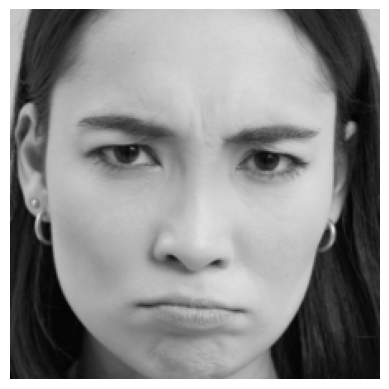

tensor([[0.3262, 0.1383, 0.1209, 0.1250, 0.2108, 0.0788]], device='cuda:0')
Predicted label index: 0
Predicted emotion: happy


In [92]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

# Load OpenCV's Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Define transformations (same as used in training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels (if needed)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def detect_and_crop_face(image_path):
    """Detects the largest face in an image and returns the cropped face."""
    image = cv2.imread(image_path)  # Read image using OpenCV
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale for detection

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print("No face detected, using the original image.")
        return Image.open(image_path)  # Return the full image if no face is found

    # Select the largest face (assuming it is the main subject)
    x, y, w, h = max(faces, key=lambda rect: rect[2] * rect[3])

    # Crop the detected face
    face_crop = image[y:y+h, x:x+w]

    # Convert cropped face to PIL image
    return Image.fromarray(cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB))

# Display the transformed image before passing it to the model
def show_transformed_image(tensor):
    """Convert a tensor back to a visual image and display it."""
    tensor = tensor.clone().detach().cpu().numpy().transpose(1, 2, 0)

    # Undo normalization
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    tensor = tensor * std + mean  # De-normalize
    tensor = np.clip(tensor, 0, 1)  # Ensure values are in range [0,1]

    plt.imshow(tensor)
    plt.axis('off')
    plt.show()


for img in ['ANG', 'DIS', 'FEA', 'HAP', 'SAD', 'SUR']:
    image_path = 'testing.jpg'#f'JAFFE_ResEmoteNet\\validation\\val_0_{img}.tiff'

    face_image = detect_and_crop_face(image_path)

    # Apply transformations
    input_tensor = transform(face_image)

    # Show the transformed face image
    show_transformed_image(input_tensor)

    # Add batch dimension and move to device
    input_tensor = input_tensor.unsqueeze(0).to(device)

    # Load model
    model.load_state_dict(torch.load('best_resnet50_fer.pth'))  # Load best model
    model.eval()

    # Run inference
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = F.softmax(outputs, dim=1)
        print(probabilities)
        _, predicted = torch.max(outputs, 1)
        predicted_label = predicted.item()

    # Label mapping
    label_map = {0: 'happy', 1: 'surprise', 2: 'sad', 3: 'anger', 4: 'disgust', 5: 'fear'}
    emotion = label_map.get(predicted_label, "Unknown")

    print(f"Predicted label index: {predicted_label}")
    print(f"Predicted emotion: {emotion}")
    break
